# Health Analysis
Done by Isabella Yan (Chisa)

## Question
How do traffic crashes, adult physical inactivity, and Divvy station accessibility relate across Chicago’s community areas, and do neighborhoods with higher physical inactivity experience different crash rates or different access to bike-share infrastructure?

## Sources
The first one I'd like to use is [Chicago Health Atlas](https://chicagohealthatlas.org/indicators/HCSPAP?topic=adult-physical-inactivity-rate) to find the traffic crashes, adult physical inactivity counts, and adult physical inactivity rates by neighborhood. The next one I'd like to use is [Divvy Bikes](https://divvybikes.com/system-data) to get the location of Divvy stops using the latitude and longtitude. Finaly, I'd like to use this [City of Chicago](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-Map/cauq-8yn6) dataset to help map latitude-longitude coordinates to a neighborhood and find the overall density of Divvy stations in each neighborhood.

### Step 1: Clean up data

In [2]:
# load in packages
import pandas as pd
import numpy as np
from shapely import wkt
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns

# load data from healthdatasets
community_boundary_data = pd.read_csv('./datasets/healthdatasets/Boundaries_-_Community_Areas_20251201.csv')
divvy_data = pd.read_csv('./datasets/healthdatasets/202412-divvy-tripdata.csv')
health_data = pd.read_csv('./datasets/healthdatasets/2024chicagohealthatlas_raw.csv')

In [3]:
#
# 1.1. Clean community area boundaries
#

# rename columns
community_boundary_data = community_boundary_data.rename(columns={
    'AREA_NUMBE': 'community_area_number',
    'COMMUNITY': 'community_area_name',
    'AREA_NUM_1': 'community_area_number_dup',
    'the_geom': 'wkt_geometry',
    'SHAPE_AREA': 'shape_area',
    'SHAPE_LEN': 'shape_length'
})

# standardize community name 
community_boundary_data['community_area_name'] = (
    community_boundary_data['community_area_name'].str.title()
)

# use wkt from shapely to convert the wkt to geometry
community_boundary_data['geometry'] = community_boundary_data['wkt_geometry'].apply(wkt.loads)

# convert to geopanda dataframe 
community_boundary_data = gpd.GeoDataFrame(
    community_boundary_data,
    geometry='geometry',
    crs="EPSG:4326"
)

# extract centroids (useful for lat/lon)
# reproject to Illinois StatePlane (good for Chicago)
boundary_projected = community_boundary_data.to_crs(epsg=3435)

# compute centroids in that CRS
centroids = boundary_projected.centroid

# convert centroids back to WGS84 (lat/lon)
centroids_wgs = centroids.to_crs(epsg=4326)

# store results
community_boundary_data['centroid_lat'] = centroids_wgs.y
community_boundary_data['centroid_lon'] = centroids_wgs.x

#
# 1.2. Clean divvy data
#

# convert all timestamps to datetime objects 
divvy_data['started_at'] = pd.to_datetime(divvy_data['started_at'])
divvy_data['ended_at'] = pd.to_datetime(divvy_data['ended_at'])

# remove invalid rides
divvy_data = divvy_data[
    (divvy_data['ended_at'] > divvy_data['started_at']) &
    (divvy_data['start_lat'].notna()) &
    (divvy_data['start_lng'].notna())
]

# create duration + data features
divvy_data['ride_minutes'] = (divvy_data['ended_at'] - divvy_data['started_at']).dt.total_seconds() / 60
divvy_data['date'] = divvy_data['started_at'].dt.date
divvy_data['hour'] = divvy_data['started_at'].dt.hour
divvy_data['day_of_week'] = divvy_data['started_at'].dt.day_name()

# connect divvy start and end points to lat and lon 
divvy_data['start_point'] = divvy_data.apply(lambda r: Point(r['start_lng'], r['start_lat']), axis=1)
divvy_data['end_point'] = divvy_data.apply(lambda r: Point(r['end_lng'], r['end_lat']), axis=1)


#
# 1.3. Clean health data 
#

# drop metadata rows
health_data = health_data.iloc[4:].reset_index(drop=True)

# rename columns to understand them    
health_data = health_data.rename(columns={
    'Name': 'community_area_name',
    'GEOID': 'community_area_number',
    'HCSPAP_2023-2024': 'physical_inactivity_rate',
    'HCSPAP_2023-2024_moe': 'physical_inactivity_rate_moe',
    'HCSPA_2023-2024': 'physical_inactivity_count',
    'HCSPA_2023-2024_moe': 'physical_inactivity_count_moe',
    'TRC_2024': 'traffic_crashes',
    'TRC_2024_moe': 'traffic_crashes_moe'
})

# standardize the names
health_data['community_area_name'] = (
    health_data['community_area_name'].str.title()
)

# convert geoid to int 
health_data['community_area_number'] = (
    health_data['community_area_number'].astype(int)
)

# drop the layer col
health_data = health_data.drop(columns=['Layer'])


### Step 2. Convert Divvy into a GeoDataframe and Assign them to Neighborhoods to Get Counts

In [4]:
#
# 2.1. Convert Divvy start points into the geoframe 
#
community_boundary_data = community_boundary_data.to_crs(epsg=3435)

# Convert Divvy points to the same CRS
divvy_gdf = gpd.GeoDataFrame(
    divvy_data,
    geometry=divvy_data['start_point'],
    crs="EPSG:4326"
).to_crs(epsg=3435)

# 
# 2.2. Assign each ride's starting neighborhood  
#
divvy_with_area = gpd.sjoin(
    divvy_gdf,
    community_boundary_data[['community_area_number', 'community_area_name', 'geometry']],
    how='left',
    predicate='within'
)


### Step 3. Get the Divvy station counts to measure the accessibility in each neighborhood. 

In [5]:
#
# 3.1. Identify only unique stations
#
unique_stations = divvy_with_area[
    ['start_station_name', 'community_area_number', 'community_area_name', 'geometry']
].drop_duplicates()

#
# 3.2. Count stations per neighborhood. 
#
station_density = (
    unique_stations
    .groupby('community_area_number')
    .size()
    .reset_index(name='divvy_station_count')
)


### Step 4: Aggregate Divvy rides and statistics per neighborhoood

In [6]:
#
# 4.1. Aggregate Divvy ride volume per community area
#
rides_per_area = (
    divvy_with_area
    .groupby('community_area_number')
    .size()
    .reset_index(name='total_rides_starting_here')
)

#
# 4.2 Merge all Divvy aggregations together
#
divvy_summary = station_density.merge(
    rides_per_area,
    on='community_area_number',
    how='left'
)

#
# 4.3. Merge Divvy summary with health data
#
community_stats = health_data.merge(
    divvy_summary,
    on='community_area_number',
    how='left'
)

community_stats = community_stats.merge(
    community_boundary_data[['community_area_number', 'geometry', 'centroid_lat', 'centroid_lon']],
    on='community_area_number',
    how='left'
)

## Step 5: Exploratory data analysis

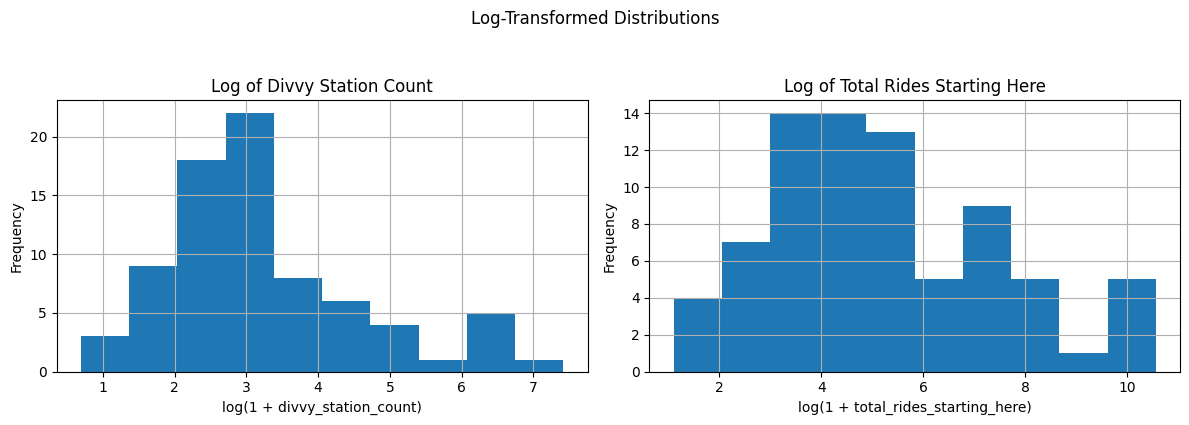

In [14]:
#
# 5.1. Check distribution of data
#

cols = [
    'physical_inactivity_rate',
    'traffic_crashes',
    'divvy_station_count',
    'total_rides_starting_here'
]

# Log-transformed histograms (for skewed variables)
log_cols = ['divvy_station_count', 'total_rides_starting_here']

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Compute log-transformed data
log_data = community_stats[log_cols].apply(np.log1p)

# Plot histograms
log_data.hist(ax=axes)

# Add titles and axis labels
axes[0].set_title("Log of Divvy Station Count")
axes[0].set_xlabel("log(1 + divvy_station_count)")
axes[0].set_ylabel("Frequency")

axes[1].set_title("Log of Total Rides Starting Here")
axes[1].set_xlabel("log(1 + total_rides_starting_here)")
axes[1].set_ylabel("Frequency")

fig.suptitle("Log-Transformed Distributions", y=1.05)

plt.tight_layout()
plt.show()


In [8]:
#
# 5.2. Look at correlations
#
community_stats[['physical_inactivity_rate',
                 'traffic_crashes',
                 'divvy_station_count',
                 'total_rides_starting_here']].corr()


,physical_inactivity_rate,traffic_crashes,divvy_station_count,total_rides_starting_here
physical_inactivity_rate,1.000000,-0.177478,-0.468223,-0.490147
traffic_crashes,-0.177478,1.000000,0.643516,0.670118
divvy_station_count,-0.468223,0.643516,1.000000,0.974841
total_rides_starting_here,-0.490147,0.670118,0.974841,1.000000


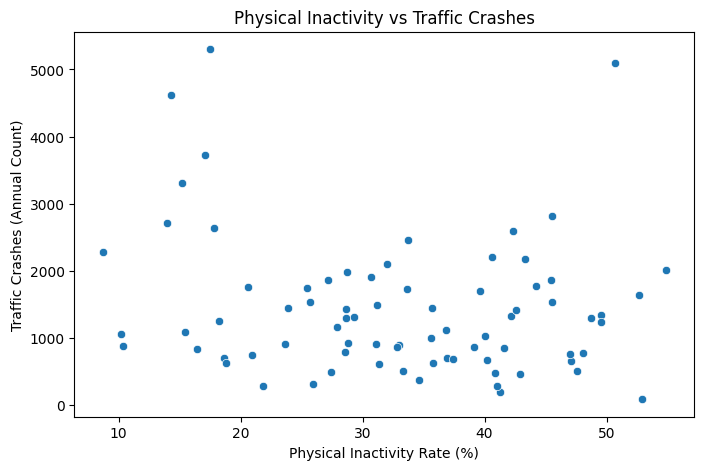

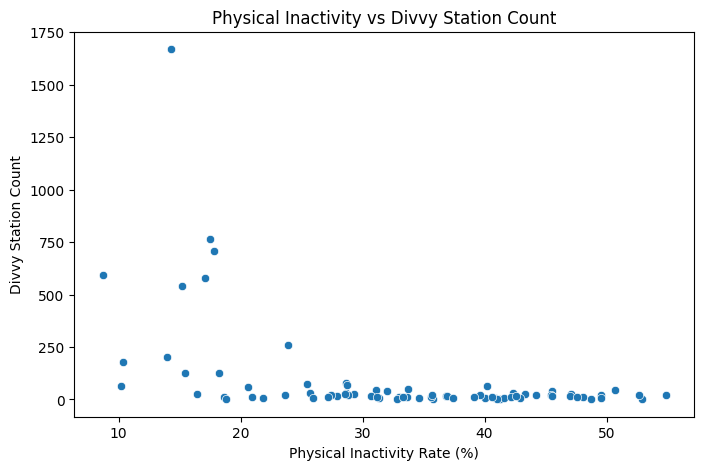

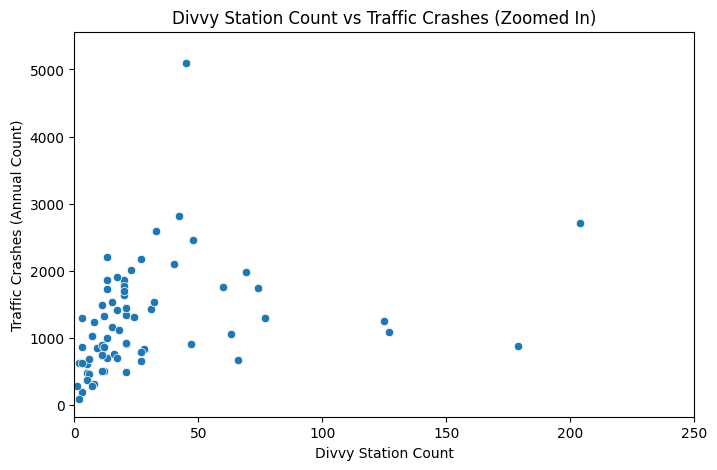

In [11]:
#
# 5.3. Use scatterplots to visualize relationships
#

# convert to numeric values
community_stats['physical_inactivity_rate'] = pd.to_numeric(
    community_stats['physical_inactivity_rate'], errors='coerce'
)

community_stats['traffic_crashes'] = pd.to_numeric(
    community_stats['traffic_crashes'], errors='coerce'
)

community_stats['divvy_station_count'] = pd.to_numeric(
    community_stats['divvy_station_count'], errors='coerce'
)

# Physical inactivity vs traffic crashes
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=community_stats,
    x='physical_inactivity_rate',
    y='traffic_crashes'
)
plt.xlabel("Physical Inactivity Rate (%)")
plt.ylabel("Traffic Crashes (Annual Count)")
plt.title("Physical Inactivity vs Traffic Crashes")
plt.show()

# Physical inactivity vs Divvy station count
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=community_stats,
    x='physical_inactivity_rate',
    y='divvy_station_count'
)
plt.xlabel("Physical Inactivity Rate (%)")
plt.ylabel("Divvy Station Count")
plt.title("Physical Inactivity vs Divvy Station Count")
plt.show()

# Divvy station count vs traffic crashes (zoomed)
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=community_stats,
    x='divvy_station_count',
    y='traffic_crashes'
)
plt.xlim(0, 250)   # zoom for better visibility
plt.xlabel("Divvy Station Count")
plt.ylabel("Traffic Crashes (Annual Count)")
plt.title("Divvy Station Count vs Traffic Crashes (Zoomed In)")
plt.show()